# The California Housing Problem

In [72]:
# importing the necessary libraries

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error

## Step 1: Importing the Dataset

In [2]:
# The dataset is extracted from ageron handson-ml github repository

housing_df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')

housing_df.head() #Displaying the first five rows of the dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Step 2: Analyzing the Data

In [3]:
# Getting a quick info of the dataset

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The info() shows that all columns have 20640 values out of 20640 except that of **total_bedrooms**. We need to take care of that later.

Moreover, all values are numerical except for the column **ocean_proximity**. So, it might be a **Categorical Attribute**. 

In [4]:
# Checking how many unique categories (along with their count) does ocean_proximity column hold

housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

So, **ocean_proximity** has only 5 categories. We will change them later to its numerical counterpart.

In [5]:
#Getting data summaries using the describe method. Fun fact to keep in ming, this doesn't include categorical variable right
#away. Instead we need to tweak it a bit for getting that.

housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


One good idea to understand the distribution of numerical data is plotting the **histograms**. So lets, do that.

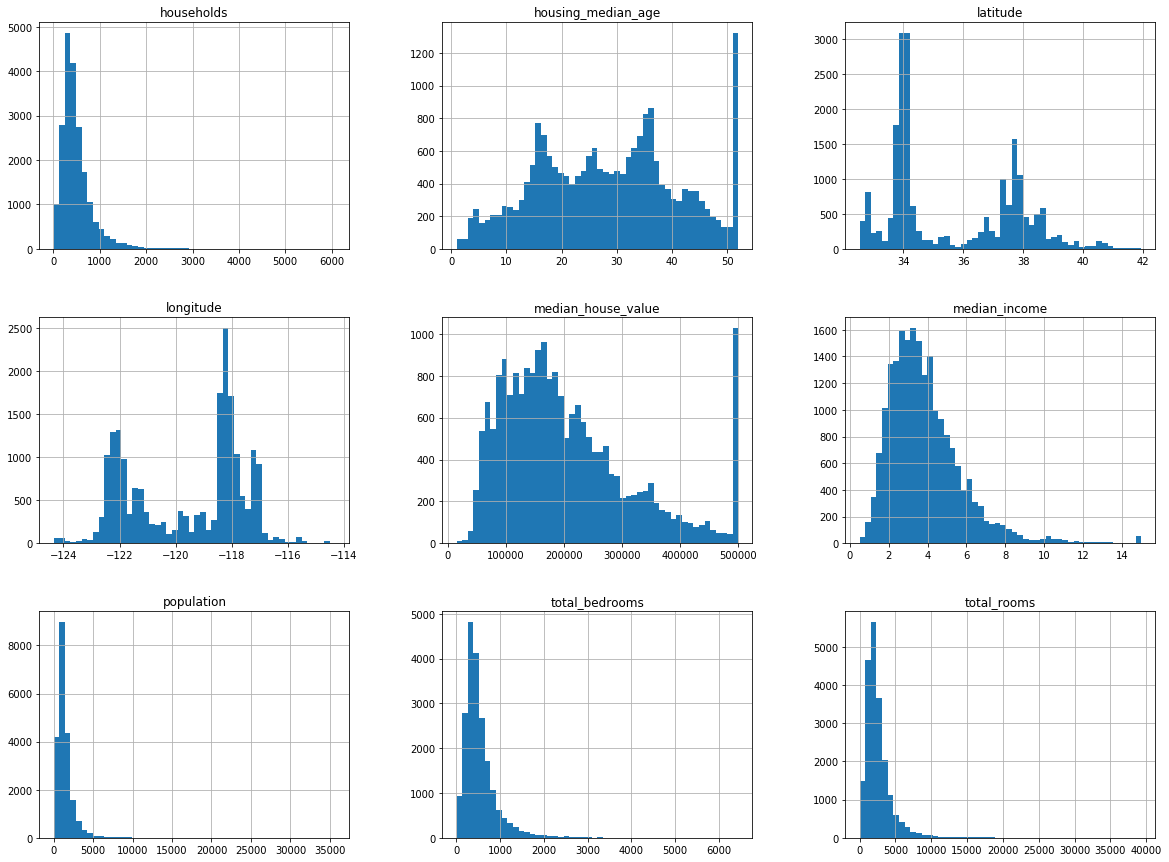

In [6]:
housing_df.hist(bins=50,figsize = (20,15)) #plotting histogram of the entire dataset
plt.show()

The histograms have given us quite a lot of insights of the data in hand.

1. Most of the data is right skewed. This might be a problem since our Machine Learning models prefer Bell shaped normal distribution. A **transformation** is something which will be needed.

2. The data are **not on similar scales**, and need to be changed for better deployment.

3. There are a lot of **capping of data**. The attributes **median_income**,**housing_median_age** and **housing_median_value** all have capped values. The housing_median_value is our target variable and its capping can be very risky and for predicting values above the capped 50K would be tougher and need different process to tackle it.

4. The **median_income** attribute is not in USD, since, it shows such small income, which is improbable. 

It is necessary to separate out the train set and the test set beforehand

Experts have stated that **median_income** is one of the major features for housing prediction. So, it is better to transform it into categorical variable to make use of it better

In [7]:
housing_df['income_cat'] = np.ceil(housing_df['median_income']/1.5) #making categories

housing_df['income_cat'].where(housing_df['income_cat'] < 5, 5.0, inplace = True) #transforming values greater than 5 to 5

In [8]:
housing_df['income_cat'].value_counts() / len(housing_df) #checking the ratio of incomes

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Spliting the data based on the income strata

In [9]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) #Provides indices for train and test data

#Set the train and test data
for train_index, test_index in split.split(housing_df, housing_df['income_cat']):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [10]:
#Dropping the extra column that we created

for sets in (strat_train_set,strat_test_set):
    sets.drop('income_cat', axis = 1, inplace = True)

In [12]:
housing = strat_train_set.copy()

One of the things given in the data is the geographic locations.
It will be great if we plot the scatter plot to get the sort of graph like structure!!

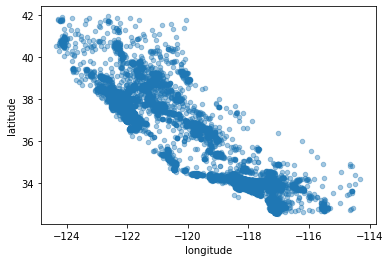

In [13]:
housing.plot(kind= 'scatter' , x = 'longitude' , y = 'latitude', alpha = '0.4')
plt.show()

One of the good things to find linear relation between two attributes is finding the **Pearson's correlation**. Since the data is small here, lets do that!

In [14]:
corr_matrix = housing.corr()

# Lets see the correlation for our target variable
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Pearson's r give us a great insight. A value of close to 1 or -1 means that the attributes are linearly correlated

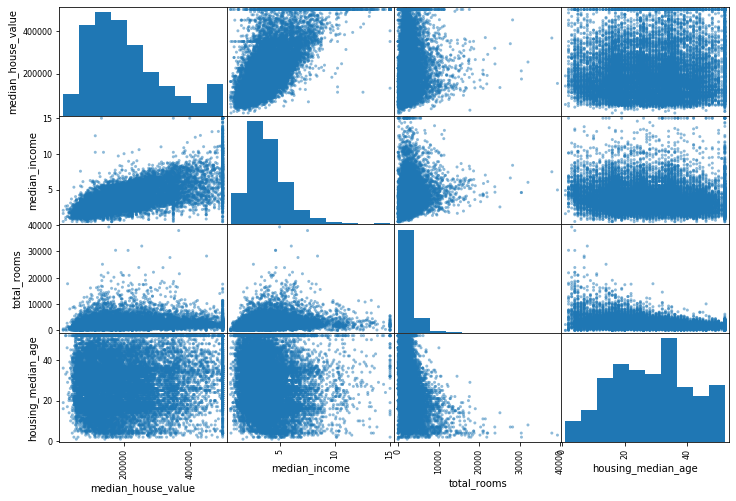

In [15]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']

scatter_matrix(housing[attributes] , figsize = (12,8))
plt.show()

One of the best attributes to predict **median_house_value** is **median_income**. So lets visalize that

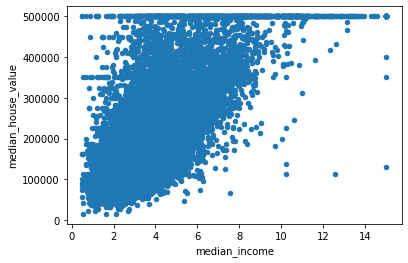

In [16]:
housing.plot(kind = 'scatter' , x = 'median_income' , y = 'median_house_value')

plt.show()

We saw there are couple of attributes in this dataset like : total_rooms, total_bedrooms , households and population. But, don't you think its quite vague to just have total_rooms as an attribute or total bedrooms.

It would make more sense if we have a total_bedrooms out of total_rooms_ratio, or a total_rooms out of households ratio and also popoluation per household ratio.

So, lets create these new features!!

In [17]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

Lets check the linear correlation now, and see if we have increased the correlation or not!

In [18]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rooms         -0.259984
Name: median_house_value, dtype: float64

Its time to analyze the data.

First lets deal with the missing values. We know we have missing values in **total_bedrooms**

In [19]:
housing_labels = strat_train_set['median_house_value'].copy()
housing = strat_train_set.drop('median_house_value',axis=1)

In [20]:
housing_features = pd.concat([housing , pd.get_dummies(housing['ocean_proximity'], drop_first = True)], sort = False , axis=1)

housing_features = housing_features.drop('ocean_proximity',axis=1)

housing_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,0,0,0,0


In [21]:
# We use the Imputer() library to use 

imputer = Imputer(strategy = 'median') #defining imputer object

#Now lets fit to Imputer

imputer.fit(housing_features) #Imputer finds the mean of each attribute
print('---Imputer Values---\n',imputer.statistics_,'\n---Medians---\n',housing_features.median().values)

X = imputer.transform(housing_features)

housing_atr = pd.DataFrame(X,columns = housing_features.columns)
housing_atr.head()

---Imputer Values---
 [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409    0.        0.        0.        0.    ] 
---Medians---
 [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409    0.        0.        0.        0.    ]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,0.0,0.0,0.0,0.0
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,0.0,0.0,0.0,0.0
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0.0,0.0,0.0,1.0
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,1.0,0.0,0.0,0.0
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,0.0,0.0,0.0,0.0


In [22]:
#Checking if there are any more missing values

housing_atr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
INLAND                0
ISLAND                0
NEAR BAY              0
NEAR OCEAN            0
dtype: int64

Voila! We have gotten rid of all the missing values!

Most Machine Learning models define themselves by seeing the value as a whole and not treat each attribute differently based on their ranges. So, it is of utmost importance, to scale them to a same range

In [23]:
minmax = MinMaxScaler() #setting up MinMaxScaler object
 
minmax.fit(housing_atr) #Fitting the data

housing_prepared = minmax.transform(housing_atr) #Transforming the data

housing_prepared

array([[0.24501992, 0.50478215, 0.7254902 , ..., 0.        , 0.        ,
        0.        ],
       [0.24103586, 0.47927736, 0.25490196, ..., 0.        , 0.        ,
        0.        ],
       [0.71215139, 0.02444208, 0.58823529, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.79183267, 0.16471838, 0.15686275, ..., 0.        , 0.        ,
        0.        ],
       [0.6314741 , 0.1360255 , 0.58823529, ..., 0.        , 0.        ,
        0.        ],
       [0.18924303, 0.55579171, 1.        , ..., 0.        , 1.        ,
        0.        ]])

All data are scaled between 0 and 1. Its time to fit it in some models

## Step 3: Model Selection and Evaluation

First lets see for Linear Regression. 

In [24]:
# Lets initialize the Linear Regression object

lr = LinearRegression()

lr.fit(housing_prepared , housing_labels)  #fitting the model

#checking the model error

score1 = cross_val_score(lr , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)

print('---For Linear Regression---\n',np.mean(np.sqrt(-score1)))

---For Linear Regression---
 69223.18594556302


Now lets try for some other models.
In particular we are going to investigate for the following models:

1. Decision Tree
2. Random Forest
3. Support Vector Machine

In [23]:
# In the following models we are going to use gridsearchCV to fine tune the hyperparameters

params = [{'criterion':['mse','mae'],
           'splitter':['best','random'],
          'max_depth':[3,5,7,9,11,13,15],
          }]

gd1 = GridSearchCV(DecisionTreeRegressor(),
                  params,
                  cv = 10,
                  scoring = 'neg_mean_squared_error',
                  n_jobs = -1)

gd1.fit(housing_prepared , housing_labels)

gd1.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [25]:
#setting up decision tree with the best hyperparameters

dt = DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

dt.fit(housing_prepared , housing_labels)

score2 = cross_val_score(dt , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)

print('---For Decision Tree---\n',np.mean(np.sqrt(-score2)))

---For Decision Tree---
 62872.393801433056


Wow, that a big leap. We have got a better score with Decision Tree than that with Linear Regression.

Lets move on and check for the other two models

First up is Random Forest.

In [25]:
#Setting up the hyperparameters

params2 = [{'criterion':['mse','mae'],
          'max_depth':[3,5,7,9,11,13,15],
          'bootstrap':['True','False']}]

grid2 = GridSearchCV(RandomForestRegressor(),
                    params2,
                    cv = 10,
                    n_jobs = -1)

grid2.fit(housing_prepared , housing_labels)

grid2.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
#initializing RandomForest object

rf = RandomForestRegressor(bootstrap='True', criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

rf.fit(housing_prepared , housing_labels)

score3 = cross_val_score(rf , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)

print('---For Random Forest---\n',np.mean(np.sqrt(-score3)))


---For Random Forest---
 52180.64177768282


Wow, that is again a massive jump. This has been the best model so far!

Lets see the last one, svr

In [28]:
#initializing the Grid Search CV

params3 = [{'kernel' : ['linear', 'rbf'],
           'C' : [ 0.03, 0.1, 0.3, 1.0, 3]}]

grid3 = GridSearchCV(SVR(),
                     params3,
                     cv = 10,
                     n_jobs = -1)

grid3.fit(housing_prepared , housing_labels)

grid3.best_estimator_

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
#Initializing SVR model

svr = SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

svr.fit(housing_prepared , housing_labels)

score4 = cross_val_score(svr , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)

print('---For SVR---\n',np.mean(np.sqrt(-score4)))


---For SVR---
 116672.31042541217


Oops! Not well. SVR is not at all a good option.

We gonna go ahead with the Random Forest model and begin processing by defining a pipeline!

Lets see what we were doing step by step then define the pipeline.

1. We separated out the Categorical Attribute and changed them into 0 and 1. This can be done in one go by the LabelBinarizer of sklearn.
2. Next what we did was with the numerical variables. We transformed the missing values with Imputers.
3. We then transformed the values into a simple scale through MinMaxScaler.
4. Then we can join the categorical and numerical attributes into a single frame to put into our model.

So, lets begin

In [59]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND


In [62]:
# changing the test set by separating the X and Y values

X_test = strat_test_set.drop('median_house_value' , axis = 1) #features
y_test = strat_test_set['median_house_value'] #target

In [67]:
housing_features_test = pd.concat([X_test , 
                                   pd.get_dummies(X_test['ocean_proximity'], 
                                                  drop_first = True)], sort = False , axis=1).drop('ocean_proximity' , axis = 1)

housing_features_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,0,0,0,0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,0,0,0,0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,0,0,0,0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,1,0,0,0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,1,0,0,0


In [68]:
test_X = imputer.transform(housing_features_test)

test_housing_atr = pd.DataFrame(test_X,columns = housing_features_test.columns)

In [69]:
housing_prepared_test = minmax.transform(test_housing_atr) #Transforming the data

housing_prepared_test

array([[0.5936255 , 0.16790648, 0.54901961, ..., 0.        , 0.        ,
        0.        ],
       [0.64641434, 0.13071201, 0.74509804, ..., 0.        , 0.        ,
        0.        ],
       [0.52788845, 0.17747078, 0.50980392, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.58366534, 0.17428268, 0.58823529, ..., 0.        , 0.        ,
        0.        ],
       [0.7001992 , 0.15409139, 0.50980392, ..., 0.        , 0.        ,
        0.        ],
       [0.54183267, 0.45164718, 0.35294118, ..., 0.        , 0.        ,
        0.        ]])

In [73]:
predictions = rf.predict(housing_prepared_test)

final_mse = mean_squared_error(y_test , predictions)

final_rmse = np.sqrt(final_mse)

final_rmse

50049.50208490981